<a href="https://colab.research.google.com/github/agron-gojcaj/TextClassificationModel/blob/main/NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk tensorflow pandas numpy scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv("train.csv")

df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
lemmatizer = WordNetLemmatizer()

# Preprocessing
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['processed_text'] = df['Description'].apply(preprocess_text)

df.head()

,Class Index,Title,Description,processed_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",reuters shortsellers wall street dwindlingband...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,reuters private investment firm carlyle groupw...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,reuters soaring crude price plus worriesabout ...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,reuters authority halted oil exportflows main ...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",afp tearaway world oil price toppling record s...


# Naive Bayes Model

In [ ]:
# Split the dataset
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(df['processed_text'], df['Class Index'], test_size=0.2, random_state=42)

In [ ]:
# Feature Extraction for Naive Bayes
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_nb)
X_test_tfidf = tfidf_vectorizer.transform(X_test_nb)

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_nb)
y_pred_nb = nb_model.predict(X_test_tfidf)

In [ ]:
# Evaluation for Naive Bayes
nb_accuracy = accuracy_score(y_test_nb, y_pred_nb)
nb_f1_score = f1_score(y_test_nb, y_pred_nb, average='weighted')

print("Naive Bayes Accuracy:", nb_accuracy)
print("Naive Bayes F1-Score:", nb_f1_score)
print("Classification Report (Naive Bayes):\n", classification_report(y_test_nb, y_pred_nb))

Naive Bayes Accuracy: 0.8842083333333334
Naive Bayes F1-Score: 0.8838327962639417
Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           1       0.89      0.88      0.89      5956
           2       0.93      0.97      0.95      6058
           3       0.85      0.85      0.85      5911
           4       0.86      0.84      0.85      6075

    accuracy                           0.88     24000
   macro avg       0.88      0.88      0.88     24000
weighted avg       0.88      0.88      0.88     24000



# CNN Model

In [ ]:
max_vocab_size = 5000  # Number of unique words to keep (vocabulary size)
max_length = 100       # Maximum length of input sequences

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(df['processed_text'], df['Class Index'], test_size=0.2, random_state=42)

# Tokenize and pad sequences for CNN
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train_cnn)

# Convert texts to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train_cnn)
X_test_seq = tokenizer.texts_to_sequences(X_test_cnn)

In [ ]:
# Pad sequences to ensure they have the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [ ]:
# Label encoding
label_encoder = LabelEncoder()
y_train_cnn = label_encoder.fit_transform(y_train_cnn)
y_test_cnn = label_encoder.transform(y_test_cnn)

In [ ]:
# CNN Model Definition
cnn_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=64, input_length=max_length),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Softmax for multi-class classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model with gradient clipping and a low learning rate to stabilize training
optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train CNN model
cnn_model.fit(X_train_pad, y_train_cnn, epochs=7, batch_size=32, validation_split=0.1)

Epoch 1/7
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.4011 - loss: 1.2580 - val_accuracy: 0.8726 - val_loss: 0.3921
Epoch 2/7
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8654 - loss: 0.4276 - val_accuracy: 0.8931 - val_loss: 0.3235
Epoch 3/7
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8917 - loss: 0.3501 - val_accuracy: 0.8991 - val_loss: 0.3074
Epoch 4/7
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9038 - loss: 0.3099 - val_accuracy: 0.9006 - val_loss: 0.3027
Epoch 5/7
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9126 - loss: 0.2865 - val_accuracy: 0.8972 - val_loss: 0.3013
Epoch 6/7
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9166 - loss: 0.2681 - val_accuracy: 0.8986 - val_loss: 0.3026
Epoch 7/7
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9208 - loss: 0.2553 - val_accuracy: 0.8981 - val_loss: 0.3051


In [ ]:
# Evaluate the CNN Model
y_pred_cnn = cnn_model.predict(X_test_pad)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)  # Convert probabilities to class predictions

750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
# Print Evaluation Metrics
print("CNN Accuracy:", accuracy_score(y_test_cnn, y_pred_cnn_classes))
print("CNN F1-Score:", f1_score(y_test_cnn, y_pred_cnn_classes, average='weighted'))
print("Classification Report (CNN):\n", classification_report(y_test_cnn, y_pred_cnn_classes))

CNN Accuracy: 0.8968333333333334
CNN F1-Score: 0.8966502749261599
Classification Report (CNN):
               precision    recall  f1-score   support

           0       0.92      0.87      0.90      5956
           1       0.94      0.97      0.95      6058
           2       0.86      0.87      0.87      5911
           3       0.87      0.87      0.87      6075

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000



# Metrics Visual Representations

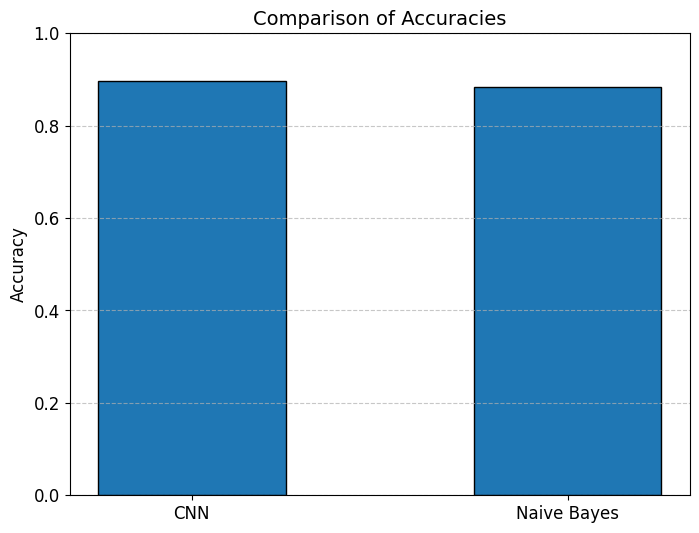

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

cnn_accuracy = accuracy_score(y_test_cnn, y_pred_cnn_classes)
nb_accuracy = accuracy_score(y_test, y_pred_nb)

models = ['CNN', 'Naive Bayes']
accuracies = [cnn_accuracy, nb_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, width=0.5, edgecolor='black')

plt.title('Comparison of Accuracies', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

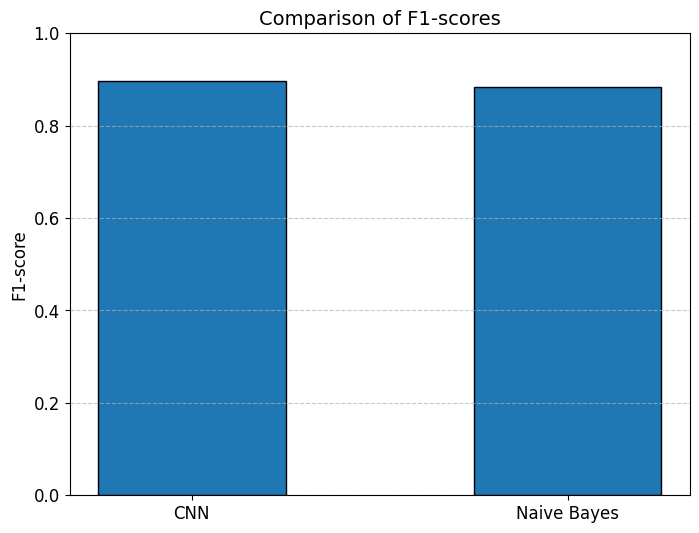

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Placeholder values for metrics
cnn_f1_score = f1_score(y_test_cnn, y_pred_cnn_classes, average='weighted')
nb_f1_score = f1_score(y_test, y_pred_nb, average='weighted')

models = ['CNN', 'Naive Bayes']
f1_scores = [cnn_f1_score, nb_f1_score]

plt.figure(figsize=(8, 6))
plt.bar(models, f1_scores, width=0.5, edgecolor='black')

plt.title('Comparison of F1-scores', fontsize=14)
plt.ylabel('F1-score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

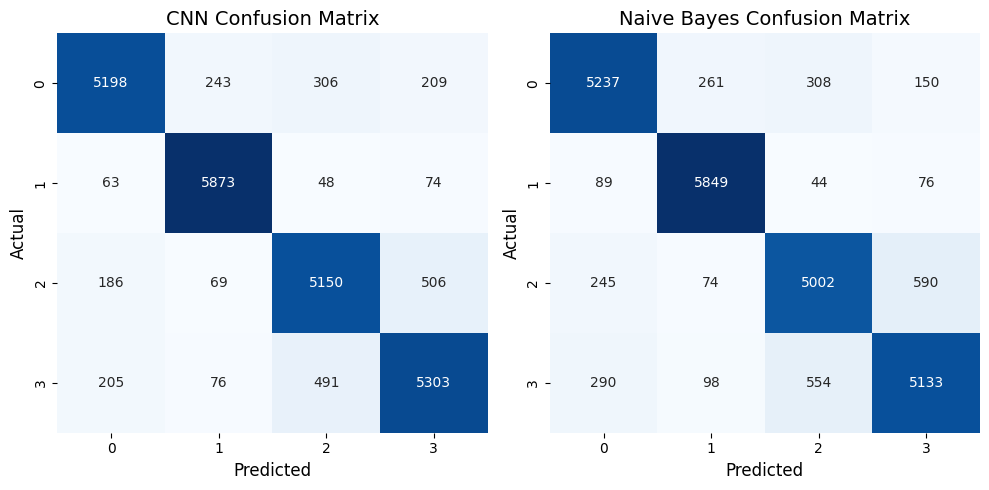

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix_cnn = confusion_matrix(y_test_cnn, y_pred_cnn_classes)
confusion_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Plotting the confusion matrix for SVM
plt.figure(figsize=(10, 5))

# SVM confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix_cnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('CNN Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)

# Gaussian Naive Bayes confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Naive Bayes Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()